In [1]:
%%capture
## Latex Plot
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

# Problem formulation

In [2]:
%%capture
!pip install gurobipy

In [3]:
%%capture
!pip install pennylane
!pip install torch_geometric

## Graphlet Function

In [4]:
import random
from collections import defaultdict

def graphleting(num_nodes, graphlet_size=4, overlap_nodes=1):
    graphlet_indices = []  # Store the indices of nodes in each graphlet

    # Generate indices for overlapping partitions
    indices = list(range(num_nodes))
    random.shuffle(indices)  # Shuffle nodes (optional)

    i = 0
    while i < num_nodes - (graphlet_size - 1):
        sub_indices = indices[i:i + graphlet_size]  # Select nodes for this graphlet
        graphlet_indices.append(sub_indices)  # Store node indices

        # Move forward while keeping overlap
        i += (graphlet_size - overlap_nodes)

    return graphlet_indices  # Return indices too

def star_subgraph(adjacency_matrix, subgraph_size=4):
    num_nodes = adjacency_matrix.shape[0]
    subgraph_indices = []
    uncovered_neighbors = set(range(num_nodes))  # All nodes should be covered as neighbors at least once

    leaf_counts = defaultdict(int)

    seed_nodes = list(range(num_nodes))
    random.shuffle(seed_nodes)

    for center_node in seed_nodes:
        neighbors = [i for i in range(num_nodes) if adjacency_matrix[center_node, i] != 0 and i != center_node]
        k = subgraph_size - 1

        candidates = neighbors  # Already excludes center node

        # Case 1: Not enough neighbors → take all of them
        if len(candidates) <= k:
            sampled_neighbors = candidates

        else:
            available_new = list(set(candidates) & uncovered_neighbors)

            # Case 2a: enough new nodes → sample from them
            if len(available_new) >= k:
                sampled_neighbors = random.sample(available_new, k)

            # Case 2b: not enough new nodes → take all + fill from candidates
            else:
                sampled_neighbors = available_new
                remaining_k = k - len(sampled_neighbors)
                remaining_pool = list(set(candidates) - set(sampled_neighbors))
                remaining_pool.sort(key=lambda x: leaf_counts[x])

                sampled_neighbors += remaining_pool[:remaining_k]

        # Update uncovered neighbor set
        uncovered_neighbors -= set(sampled_neighbors)
        for node in sampled_neighbors:
            leaf_counts[node] += 1

        # Add center + its sampled neighbors
        subgraph = [center_node] + sampled_neighbors
        subgraph_indices.append(subgraph)

    return subgraph_indices

# New QML

In [5]:
import pennylane as qml


def circuit_1(weights, wires):
    for idx, wire in enumerate(wires):
        qml.RX(weights[idx, 0], wires=wire)
        qml.RZ(weights[idx, 1], wires=wire)

def circuit_2(weights, wires):
    for idx, wire in enumerate(wires):
        qml.RX(weights[idx, 0], wires=wire)
        qml.RZ(weights[idx, 1], wires=wire)
    for idx, wire in enumerate(wires[:-1]):
        qml.CNOT(wires=[wire, wires[idx+1]])

def circuit_3(weights, wires):
    for idx, wire in enumerate(wires):
        qml.RX(weights[idx], wires=wire)
        qml.RZ(weights[idx], wires=wire)

def circuit_13(weights, wires):
    for idx, wire in enumerate(wires):
        qml.RY(weights[idx, 0], wires=wire)
    for idx, wire in enumerate(wires[::-1]):
        qml.CRZ(weights[idx, 1], wires=[wire, wires[-(idx)]])

    for idx, wire in enumerate(wires):
        qml.RY(weights[idx, 2], wires=wire)
    target =  wires[1:] + wires[:1]
    for idx, wire in enumerate(wires[-1:] + wires[:-1]):
        qml.CRZ(weights[idx, 3], wires=[wire, target[idx]])


def circuit_139(weights, wires):
    for idx, wire in enumerate(wires):
        qml.RY(weights[idx, 0], wires=wire)
    for idx, wire in enumerate(wires[::-1]):
        qml.CRZ(weights[idx, 1], wires=[wire, wires[-(idx)]])

    for idx, wire in enumerate(wires):
        qml.RY(weights[idx, 2], wires=wire)
    target =  wires[1:] + wires[:1]
    for idx, wire in enumerate(wires[-1:] + wires[:-1]):
        qml.CRZ(weights[idx, 1], wires=[wire, target[idx]])

def circuit_14(weights, wires):
    for idx, wire in enumerate(wires):
        qml.RY(weights[idx, 0], wires=wire)
    for idx, wire in enumerate(wires[::-1]):
        qml.CRX(weights[idx, 1], wires=[wire, wires[-(idx)]])

    for idx, wire in enumerate(wires):
        qml.RY(weights[idx, 2], wires=wire)
    target =  wires[1:] + wires[:1]
    for idx, wire in enumerate(wires[-1:] + wires[:-1]):
        qml.CRX(weights[idx, 3], wires=[wire, target[idx]])

def circuit_15(weights, wires):
    for idx, wire in enumerate(wires):
        qml.RY(weights[idx, 0], wires=wire)
    for idx, wire in enumerate(wires[::-1]):
        qml.CNOT(wires=[wire, wires[-(idx)]])

    for idx, wire in enumerate(wires):
        qml.RY(weights[idx, 1], wires=wire)
    target =  wires[1:] + wires[:1]
    for idx, wire in enumerate(wires[-1:] + wires[:-1]):
        qml.CNOT(wires=[wire, target[idx]])




def custom_pqc(weights, wires, mode=1):
    if mode == 1:
        circuit_1(weights, wires)
    elif mode == 2:
        circuit_2(weights, wires)
    elif mode == 3:
        circuit_3(weights, wires)
    elif mode == 13:
        circuit_13(weights, wires)
    elif mode == 14:
        circuit_14(weights, wires)
    elif mode == 15:
        circuit_15(weights, wires)

In [6]:
import torch
import torch.nn as nn
from pennylane import numpy as np
import pennylane as qml



def qgnn_layer_4(theta, num_edges):
    qml.StronglyEntanglingLayers(weights=theta, wires=[0, num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.StronglyEntanglingLayers(weights=theta, wires=[1, num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.StronglyEntanglingLayers(weights=theta, wires=[2, num_edges+0, num_edges+1])
    qml.StronglyEntanglingLayers(weights=theta, wires=[3, num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.StronglyEntanglingLayers(weights=theta, wires=[4, num_edges+2, num_edges+3])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.StronglyEntanglingLayers(weights=theta, wires=[5, num_edges+2, num_edges+3])

def custom_4(theta, num_edges, num_mode):
    custom_pqc(weights=theta, wires=[0, num_edges+0, num_edges+1],mode=num_mode)
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    custom_pqc(weights=theta, wires=[1, num_edges+1, num_edges+2],mode=num_mode)
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    custom_pqc(weights=theta, wires=[2, num_edges+0, num_edges+1],mode=num_mode)
    custom_pqc(weights=theta, wires=[3, num_edges+1, num_edges+2],mode=num_mode)
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    custom_pqc(weights=theta, wires=[4, num_edges+2, num_edges+3],mode=num_mode)
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    custom_pqc(weights=theta, wires=[5, num_edges+2, num_edges+3],mode=num_mode)


def qgnn_layer_4_Basic(theta, num_edges):
    qml.BasicEntanglerLayers(weights=theta, wires=[0, num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.BasicEntanglerLayers(weights=theta, wires=[1, num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.BasicEntanglerLayers(weights=theta, wires=[2, num_edges+0, num_edges+1])
    qml.BasicEntanglerLayers(weights=theta, wires=[3, num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.BasicEntanglerLayers(weights=theta, wires=[4, num_edges+2, num_edges+3])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.BasicEntanglerLayers(weights=theta, wires=[5, num_edges+2, num_edges+3])

def unpack_inputs_single(inputs):
    adjacency_matrix = inputs[:num_edges_model].reshape(-1, num_edges_model)
    node_features = inputs[num_edges_model:].reshape(-1, num_nodes_model)
    return adjacency_matrix, node_features



In [7]:
def qgnn_layer_5_Basic(theta, num_edges):
    qml.BasicEntanglerLayers(weights=theta, wires=[0, num_edges+0, num_edges + 1])
    qml.SWAP(wires = [num_edges + 0, num_edges+1])
    qml.BasicEntanglerLayers(weights=theta, wires=[1, num_edges+1, num_edges + 2])
    qml.SWAP(wires = [num_edges + 1, num_edges+2])
    qml.BasicEntanglerLayers(weights=theta, wires=[2, num_edges+2, num_edges + 3])
    qml.SWAP(wires = [num_edges + 2, num_edges + 3])
    qml.BasicEntanglerLayers(weights=theta, wires=[3, num_edges+3, num_edges + 4])
    qml.BasicEntanglerLayers(weights=theta, wires=[4, num_edges+0, num_edges + 1])
    qml.SWAP(wires = [num_edges+0, num_edges+1])
    qml.BasicEntanglerLayers(weights=theta, wires=[5, num_edges+1, num_edges + 2])
    qml.SWAP(wires = [num_edges+1, num_edges+2])
    qml.SWAP(wires = [num_edges+2, num_edges+3])
    qml.BasicEntanglerLayers(weights=theta, wires=[6, num_edges+3, num_edges + 4])
    qml.BasicEntanglerLayers(weights=theta, wires=[7, num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+2, num_edges+3])
    qml.BasicEntanglerLayers(weights=theta, wires=[8, num_edges+3, num_edges+4])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+2, num_edges+3])
    qml.BasicEntanglerLayers(weights=theta, wires=[9, num_edges+3, num_edges+4])

def qgnn_layer_5(theta, num_edges):
    qml.StronglyEntanglingLayers(weights=theta, wires=[0, num_edges+0, num_edges + 1])
    qml.SWAP(wires = [num_edges + 0, num_edges+1])
    qml.StronglyEntanglingLayers(weights=theta, wires=[1, num_edges+1, num_edges + 2])
    qml.SWAP(wires = [num_edges + 1, num_edges+2])
    qml.StronglyEntanglingLayers(weights=theta, wires=[2, num_edges+2, num_edges + 3])
    qml.SWAP(wires = [num_edges + 2, num_edges + 3])
    qml.StronglyEntanglingLayers(weights=theta, wires=[3, num_edges+3, num_edges + 4])
    qml.StronglyEntanglingLayers(weights=theta, wires=[4, num_edges+0, num_edges + 1])
    qml.SWAP(wires = [num_edges+0, num_edges+1])
    qml.StronglyEntanglingLayers(weights=theta, wires=[5, num_edges+1, num_edges + 2])
    qml.SWAP(wires = [num_edges+1, num_edges+2])
    qml.SWAP(wires = [num_edges+2, num_edges+3])
    qml.StronglyEntanglingLayers(weights=theta, wires=[6, num_edges+3, num_edges + 4])
    qml.StronglyEntanglingLayers(weights=theta, wires=[7, num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+2, num_edges+3])
    qml.StronglyEntanglingLayers(weights=theta, wires=[8, num_edges+3, num_edges+4])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+2, num_edges+3])
    qml.StronglyEntanglingLayers(weights=theta, wires=[9, num_edges+3, num_edges+4])

def custom_5(theta, num_edges, mode=1):
    custom_pqc(weights=theta, wires=[0, num_edges+0, num_edges + 1], mode=mode)
    qml.SWAP(wires = [num_edges + 0, num_edges+1])
    custom_pqc(weights=theta, wires=[1, num_edges+1, num_edges + 2], mode=mode)
    qml.SWAP(wires = [num_edges + 1, num_edges+2])
    custom_pqc(weights=theta, wires=[2, num_edges+2, num_edges + 3], mode=mode)
    qml.SWAP(wires = [num_edges + 2, num_edges + 3])
    custom_pqc(weights=theta, wires=[3, num_edges+3, num_edges + 4], mode=mode)
    custom_pqc(weights=theta, wires=[4, num_edges+0, num_edges + 1], mode=mode)
    qml.SWAP(wires = [num_edges+0, num_edges+1])
    custom_pqc(weights=theta, wires=[5, num_edges+1, num_edges + 2])
    qml.SWAP(wires = [num_edges+1, num_edges+2])
    qml.SWAP(wires = [num_edges+2, num_edges+3])
    custom_pqc(weights=theta, wires=[6, num_edges+3, num_edges + 4], mode=mode)
    custom_pqc(weights=theta, wires=[7, num_edges+0, num_edges+1], mode=mode)
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+2, num_edges+3])
    custom_pqc(weights=theta, wires=[8, num_edges+3, num_edges+4], mode=mode)
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+2, num_edges+3])
    custom_pqc(weights=theta, wires=[9, num_edges+3, num_edges+4], mode=mode)


In [8]:
def star_pqc(theta, num_edges, mode=1):
    for i in range(num_edges):
        custom_pqc(weights=theta, wires=[i, num_edges+0, num_edges+i+1], mode=mode)

## QNode

In [9]:
num_nodes_model = 6
sub_mode = 'star'

num_layers = 1
num_ent_lay = 1
mode = 'custom' #'strong
mode_num = 13
hop_neighbor = 2

if sub_mode == 'random':
    num_edges_model = int(num_nodes_model * (num_nodes_model-1)/2)
elif sub_mode == 'star':
    num_edges_model = num_nodes_model - 1
n_qubits = num_nodes_model + num_edges_model

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch', diff_method='backprop')
def qgnn_circuit(inputs, weights):
    adjacency_matrix, vertex_features = unpack_inputs_single(inputs)

    for i in range(num_edges_model):
        # qml.AmplitudeEmbedding(features=adjacency_matrix[:,i], wires=i, normalize=True, pad_with=0.)
        qml.RY(adjacency_matrix[:,i], wires=i)
    for i in range(num_nodes_model):
        # qml.AmplitudeEmbedding(features=vertex_features[:,i], wires=num_edges_model+i, normalize=True, pad_with=0.)
        qml.RY(vertex_features[:,i], wires=num_edges_model + i)
    for each_lay in range(num_layers):
        if sub_mode == 'random':
            if num_nodes_model == 4:
                if mode == 'strong':
                    qgnn_layer_4(weights[each_lay].to(torch.float32),num_edges_model)
                elif mode == 'basic':
                    qgnn_layer_4_Basic(weights[each_lay].to(torch.float32),num_edges_model)
                elif mode == 'custom':
                    custom_4(weights[each_lay].to(torch.float32),num_edges_model,mode_num)
            elif num_nodes_model == 5:
                if mode == 'strong':
                    qgnn_layer_5(weights[each_lay].to(torch.float32),num_edges_model)
                elif mode == 'basic':
                    qgnn_layer_5_Basic(weights[each_lay].to(torch.float32),num_edges_model)
                elif mode == 'custom':
                    custom_5(weights[each_lay].to(torch.float32),num_edges_model,mode_num)
        elif sub_mode == 'star':
            star_pqc(weights[each_lay].to(torch.float32),num_edges_model,mode_num)

    # return [qml.expval(qml.PauliZ(num_edges_model))]
    return [qml.expval(qml.PauliZ(i)) for i in range(num_edges_model,n_qubits)]
    # return qml.probs(wires=list(range(num_edges_model, n_qubits)))

## Model

In [10]:
import copy

class QgnnNode(nn.Module):
    def __init__(self, w_shapes,  node_input_dim=2, edge_input_dim=2,
                 graphlet_size=4, overlap_size=1):
        super().__init__()
        self.input_node = torch.nn.Sequential(
                                # torch.nn.Linear(2, 4),
                                # torch.nn.Sigmoid(),
                                torch.nn.Linear(node_input_dim, 1),
                                torch.nn.Sigmoid()
                            )
        self.input_edge = torch.nn.Sequential(
                                # torch.nn.Linear(2, 4),
                                # torch.nn.Sigmoid(),
                                torch.nn.Linear(edge_input_dim, 1),
                                torch.nn.Sigmoid()
                            )
        self.qconv = qml.qnn.TorchLayer(qgnn_circuit, w_shapes)
        self.reLU = torch.nn.ReLU()
        # self.qconv = torch.nn.Sequential( *[self.qconv, self.reLU])
        self.graphlet_size = graphlet_size
        self.overlap_size = overlap_size
        # self.final = nn.Sequential(
        #     nn.Linear(1, 16),
        #     nn.ReLU(),
        #     nn.Linear(16, 1),
        #     nn.Sigmoid()
        # )

    def forward(self, node_feat, edge_attr, edge_index):
        num_nodes = node_feat.shape[0]
        all_feat = {}

        # Save diagonal features first
        for i in range(num_nodes):
            all_feat[f"{i}_{i}"] = self.input_node(node_feat[i]).squeeze()

        # Now set features for edge pairs
        for idx, (i, j) in enumerate(edge_index):
            edge_feat = edge_attr[idx]
            all_feat[f"{i}_{j}"] = self.input_edge(edge_feat).squeeze()

        adj_mtx = np.zeros((num_nodes, num_nodes))
        for i, j in edge_index:
            adj_mtx[i, j] = 1
            adj_mtx[j, i] = 1
        graphlets = star_subgraph(adj_mtx, subgraph_size=self.graphlet_size)

        for _ in range(hop_neighbor):
            all_feat_upd = all_feat.copy()
            for each_graphlet in graphlets:
                center = each_graphlet[0]
                neighbors = each_graphlet[1:]

                subgraph_features = torch.stack([
                    all_feat[f"{min(center, neighbor)}_{max(center, neighbor)}"]
                    for neighbor in neighbors
                ])
                node_features = torch.stack([
                    all_feat[f"{node}_{node}"] for node in each_graphlet
                ])
                while len(subgraph_features) < num_edges_model:
                    subgraph_features = torch.cat([subgraph_features, torch.tensor([0.0])],dim=0)
                while len(node_features) < num_nodes_model:
                    node_features = torch.cat([node_features, torch.tensor([0.0])],dim=0)

                inputs = torch.cat([subgraph_features, node_features], dim=0)
                x = self.qconv(inputs)
                x = self.reLU(x)

                all_feat_upd[f"{center}_{center}"] = x[0]

            all_feat = all_feat_upd

        final_node_embeddings = torch.stack([all_feat[f"{i}_{i}"]for i in range(num_nodes)])
        # final_node_embeddings = torch.stack([self.final(all_feat[f"{i}_{i}"].view(1)).squeeze() for i in range(num_nodes)])
        return final_node_embeddings

In [11]:
class QGNNGraphClassifier(nn.Module):
    def __init__(self, base_model, hidden_dim=1):
        super().__init__()
        self.base_model = base_model
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            # nn.Sigmoid()
        )

    def forward(self, node_feat, edge_attr, edge_index, batch):
        node_embeddings = self.base_model(node_feat, edge_attr, edge_index)
        graph_embedding = global_mean_pool(node_embeddings, batch)
        return self.classifier(graph_embedding)

In [12]:

# weight_shapes = {"weights": (num_layers, num_ent_lay, 3, 3)} # Strong
if mode == 'strong':
    weight_shapes = {"weights": (num_layers, num_ent_lay, 3, 3)} # Strong
elif mode == 'basic':
    weight_shapes = {"weights": (num_layers, num_ent_lay, 3)}
elif mode == 'custom':
    if mode_num == 1:
        weight_shapes = {"weights": (num_layers, 3, 2)} # custom circuit 1
    elif mode_num == 13:
        weight_shapes = {"weights": (num_layers, 3, 4)} # circuit 13
    elif mode_num == 14:
        weight_shapes = {"weights": (num_layers, 3, 4)} # circuit 13
    elif mode_num == 15:
        weight_shapes = {"weights": (num_layers, 3, 2)} # circuit 13
    elif mode_num == 139:
        weight_shapes = {"weights": (num_layers, 3, 3)} # circuit 13



adjacency_matrix = torch.rand(1, num_edges_model, dtype=torch.float32)
vertex_features = torch.rand(1, num_nodes_model, dtype=torch.float32)
adjacency_matrix = adjacency_matrix.reshape(-1)
vertex_features = vertex_features.reshape(-1)
weights = torch.tensor(np.random.uniform(low=0, high=np.pi, size=weight_shapes['weights']), dtype=torch.float32, requires_grad=True)
inputs = torch.cat((adjacency_matrix, vertex_features), dim=0)
# test_model = QuantumGraphNetwork()
# test_model(adjacency_matrix, vertex_features)
# print(qml.draw(qgnn_node)(inputs,weights))

In [13]:
weight_shapes

{'weights': (1, 3, 4)}

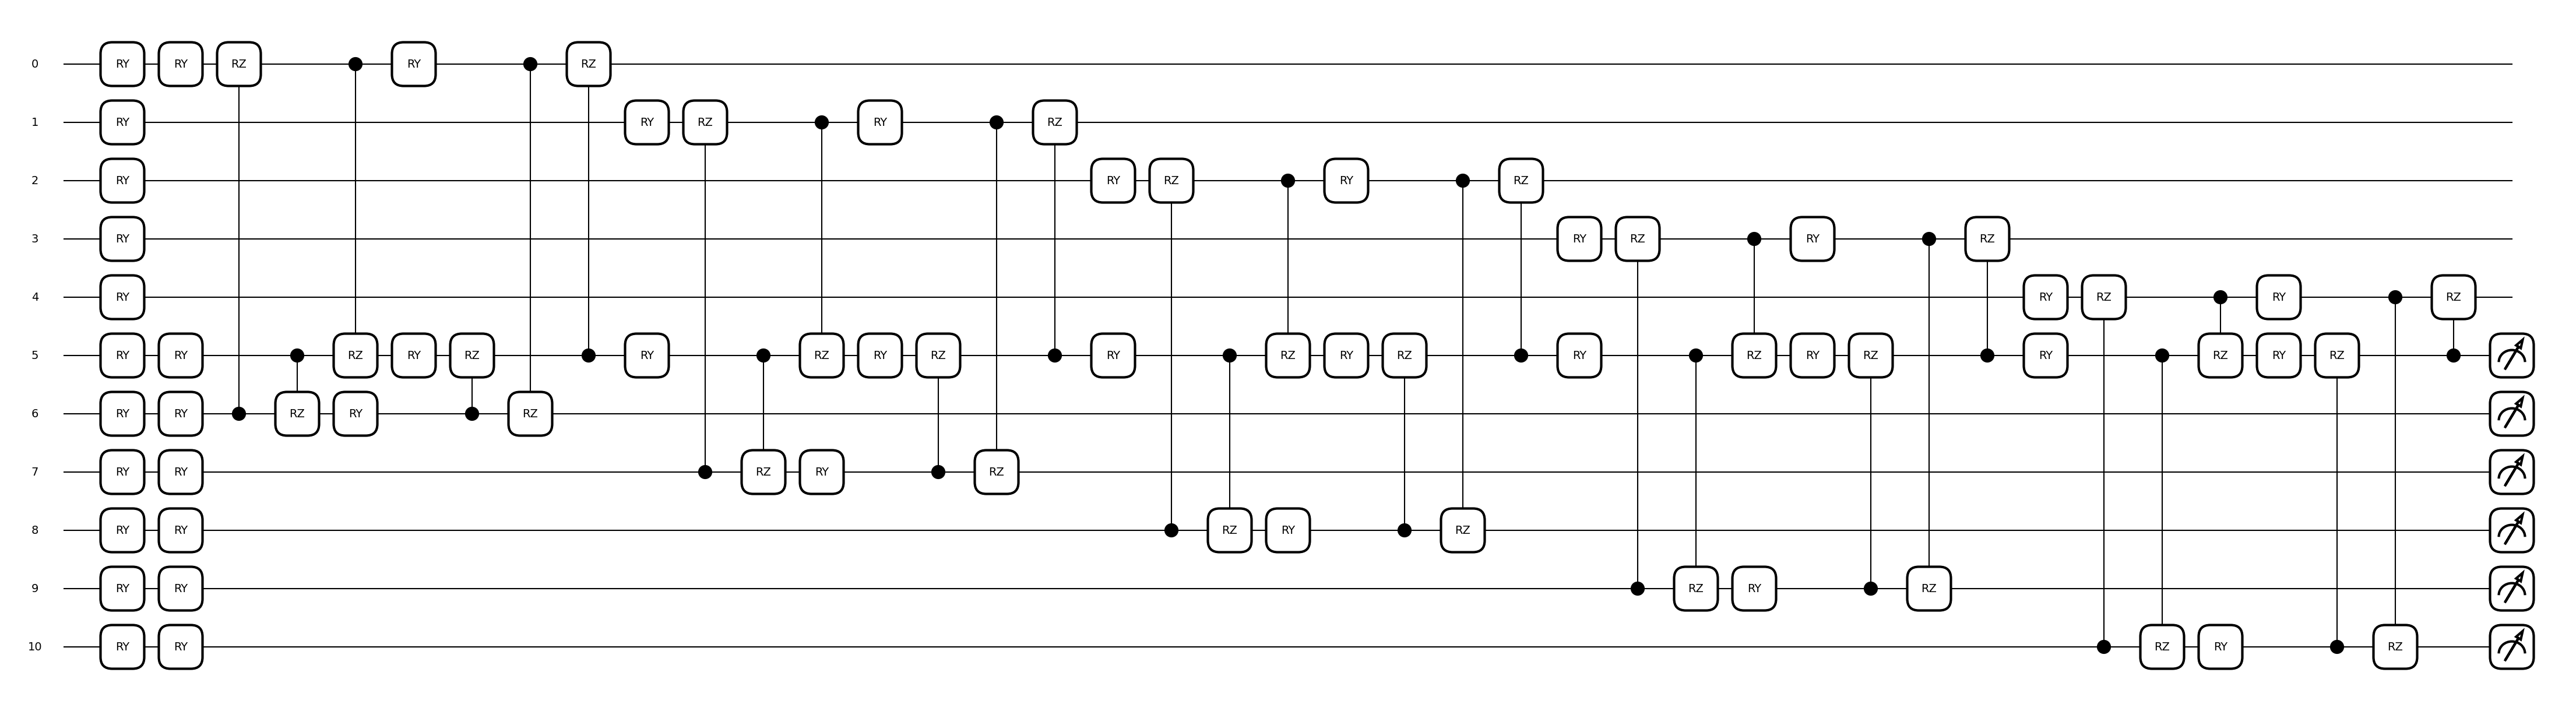

In [14]:
import matplotlib.pyplot as plt


fig, ax = qml.draw_mpl(qgnn_circuit)(inputs,weights)
plt.show()

# Training and Testing

In [15]:
def cora_to_qgnn_input(data):
    node_feat = data.x  # [num_nodes, num_features]
    edge_index = data.edge_index.T.tolist()  # List of (i, j) edges
    edge_attr = []

    for i, j in edge_index:
        edge_attr.append(torch.tensor([1.0]))  # Dummy symmetric value

    edge_attr = torch.stack(edge_attr)

    return node_feat, edge_attr, edge_index, data.y


In [16]:
import pickle
# criterion = nn.BCELoss()

def train_cora(model, data, optimizer, criterion):
    model.train()
    node_feat, edge_attr, edge_index, labels = cora_to_qgnn_input(data)

    node_feat = node_feat.to(device)
    edge_attr = edge_attr.to(device)
    edge_index = torch.tensor(edge_index).to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    output = model(node_feat, edge_attr, edge_index)

    loss = criterion(output[data.train_mask], labels[data.train_mask])
    loss.backward()
    optimizer.step()

    pred = output.argmax(dim=1)
    acc = (pred[data.train_mask] == labels[data.train_mask]).float().mean().item()
    return loss.item(), acc


def test_cora(model, data):
    model.eval()
    node_feat, edge_attr, edge_index, labels = cora_to_qgnn_input(data)

    node_feat = node_feat.to(device)
    edge_attr = edge_attr.to(device)
    edge_index = torch.tensor(edge_index).to(device)
    labels = labels.to(device)

    with torch.no_grad():
        output = model(node_feat, edge_attr, edge_index)
        pred = output.argmax(dim=1)

    accs = {}
    for split in ['train', 'val', 'test']:
        mask = getattr(data, f"{split}_mask")
        acc = (pred[mask] == labels[mask]).float().mean().item()
        accs[split] = acc
    return accs


def quantize_output(output, num_levels=4):
    levels = torch.linspace(0, 1, steps=num_levels, device=output.device)
    # Find closest level for each output value
    quantized_output = torch.zeros_like(output)
    for i in range(output.shape[0]):
        quantized_output[i] = levels[torch.argmin(torch.abs(levels - output[i]))]
    return quantized_output


def sum_weighted_rate(h, p, w, n0):

    all_signal = torch.square(h * p.view(-1, 1))
    des_signal = torch.diag(all_signal)
    rx_signal = torch.sum(all_signal, dim=0)
    inteference = rx_signal - des_signal + n0

    sinr = des_signal/inteference
    w_sumrate = torch.log2(1 + sinr * w)
    return torch.sum(w_sumrate)

In [17]:
import torch.nn.functional as F

def preprocess_graph_input(data):

    node_feat = data.x  # [num_nodes, num_node_features]
    edge_index = data.edge_index.t().tolist()  # list of (i, j)
    edge_attr = F.one_hot(data.edge_attr.long().view(-1), num_classes=4).float()

    return node_feat, edge_attr, edge_index, data.y


In [18]:
from torch_geometric.nn import global_mean_pool

thr = 0.5

def train_mutag(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0

    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        node_feat, edge_attr, edge_index, y = preprocess_graph_input(data)
        node_feat = node_feat.to(device)
        edge_attr = edge_attr.to(device)
        edge_index =  torch.tensor(edge_index).to(device)
        y = y.float().to(device)

        # Your model must return a graph-level output (e.g., pooling over nodes)
        batch = data.batch.to(device)  # ← Needed for graph pooling
        out = model(node_feat, edge_attr, edge_index, batch)
        # out = global_mean_pool(node_embeddings, batch)

        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        out_detached = out.detach()
        pred = (out_detached.view(-1) > thr).long()
        correct += (pred == y).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)


def test_mutag(model, loader, device):
    model.eval()
    correct = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            node_feat, edge_attr, edge_index, y = preprocess_graph_input(data)
            node_feat = node_feat.to(device)
            edge_attr = edge_attr.to(device)
            edge_index = torch.tensor(edge_index).to(device)
            y = y.float().to(device)

            # Your model must return a graph-level output (e.g., pooling over nodes)
            batch = data.batch.to(device)  # ← Needed for graph pooling
            out = model(node_feat, edge_attr, edge_index, batch)
            # out = global_mean_pool(node_embeddings, batch)

            pred = (out.view(-1) > thr).long()
            correct += (pred == y).sum().item()

    return correct / len(loader.dataset)

# Main

In [19]:
# Hyperparameters and setup
training_sam = 100
testing_sam = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [20]:
setup_overlap = 1
if mode == 'strong':
    param_shape = {"weights": (num_layers, num_ent_lay, 3, 3)} # Strong
elif mode == 'basic':
    param_shape = {"weights": (num_layers, num_ent_lay, 3)}
elif mode == 'custom':
    if mode_num == 1:
        param_shape = {"weights": (num_layers, 3, 2)} # custom circuit 1
    elif mode_num == 13:
        param_shape = {"weights": (num_layers, 3, 4)} # circuit 13
print(param_shape)


{'weights': (1, 3, 4)}


# Training and Testing

## Node Classification

### Cora

In [31]:
%%capture
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0].to(device)
num_node_features = dataset.num_node_features
num_classes = dataset.num_classes

In [45]:
edge_index = data.edge_index.T  # shape [num_edges, 2]
num_edges = edge_index.shape[0]

edge_attr = torch.ones((num_edges, 0), dtype=torch.float32).to(edge_index.device)
data.edge_attr = edge_attr

In [49]:
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
coraModel= QgnnNode(
    w_shapes=param_shape,
    node_input_dim=num_node_features,
    edge_input_dim=0,
    graphlet_size=num_nodes_model,
    overlap_size=setup_overlap
).to(device)
optimizer_cora = optim.Adam(coraModel.parameters(), lr=0.05)
scheduler_cora = torch.optim.lr_scheduler.StepLR(optimizer_cora, step_size=2, gamma=0.5)


In [50]:
def train_node_classification(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_attr, data.edge_index.T)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test_node_classification(model, data):
    model.eval()
    out = model(data.x, data.edge_attr, data.edge_index.T)
    pred = out.argmax(dim=1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (pred[mask] == data.y[mask]).sum()
        accs.append(int(correct) / int(mask.sum()))
    return accs  # [train_acc, val_acc, test_acc]

In [ ]:
for epoch in range(1, 10):
    loss = train_node_classification(coraModel, data, optimizer_cora)
    train_acc, val_acc, test_acc = test_node_classification(coraModel, data)
    print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")


## Graph Data

In [23]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import torch_geometric
from torch_geometric.datasets import TUDataset


# dataset = Planetoid(root='data/CORA', name='Cora', transform=NormalizeFeatures())

dataset = TUDataset(root='data/TUDataset', name='MUTAG')
data = dataset[0]  # each data is a small graph
# num_node = data.x.shape[1]
data_node_feat = data.x.shape[1]
data_edge_feat = data.edge_attr.shape[1]


Processing...
Done!


In [24]:
train_sam = 100
test_sam = 50

In [25]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='data/TUDataset', name='MUTAG')
data_node_feat = dataset[0].x.shape[1]

# Optional: shuffle and split manually
torch.manual_seed(303)
dataset = dataset.shuffle()
train_dataset = dataset[:train_sam]
test_dataset = dataset[train_sam:train_sam+test_sam]

train_loader = DataLoader(train_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)

In [26]:
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseModel= QgnnNode(
    w_shapes=param_shape,
    node_input_dim=data_node_feat,
    edge_input_dim=data_edge_feat,
    graphlet_size=num_nodes_model,
    overlap_size=setup_overlap
).to(device)
model = QGNNGraphClassifier(baseModel, hidden_dim=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
# criterion = torch.nn.BCELoss()
criterion = torch.nn.BCEWithLogitsLoss()


In [27]:
train_losses = []
train_accs = []
test_accs = []

epochs = 10
for epoch in range(1, epochs):
    loss, train_acc = train_mutag(model, train_loader, optimizer, criterion, device)
    test_acc = test_mutag(model, test_loader, device)

    scheduler.step()
    train_losses.append(loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch 001, Loss: 0.6666, Train Acc: 0.4600, Test Acc: 0.5800
Epoch 002, Loss: 0.6432, Train Acc: 0.5300, Test Acc: 0.5800
Epoch 003, Loss: 0.6347, Train Acc: 0.6800, Test Acc: 0.5800
Epoch 004, Loss: 0.6341, Train Acc: 0.6800, Test Acc: 0.5800
Epoch 005, Loss: 0.6305, Train Acc: 0.6800, Test Acc: 0.5800
Epoch 006, Loss: 0.6304, Train Acc: 0.6800, Test Acc: 0.5800


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
total_label = 0
num_batch = 0
for _, _, opt_sinr, _ in train_loader:
    total_label += opt_sinr
    num_batch += 1
train_label = total_label/num_batch

total_label = 0
num_batch = 0
for _, _, opt_sinr, _ in test_loader:
    total_label += opt_sinr
    num_batch += 1
test_label = total_label/num_batch

In [ ]:
import matplotlib.pyplot as plt


plt.rc("text", usetex=True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), training_sinr, label='Training Sum Rate', marker='o', color='b')
plt.plot(range(1, num_epochs+1), testing_sinr, label='Testing Sum Rate', marker='s', color='r')
# plt.axhline(y=train_label, color='black', linestyle='-', label='Optimal SINR')
plt.axhline(y=train_label, color='black', linestyle='-', label='WMMSE')

plt.title('Unsupervised Setting')
plt.xlabel('Epoch')
plt.ylabel('SINR')
plt.xticks(range(1, num_epochs+1))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
eval_sam = 200
eval_dataset = d2dDataset(num_samples=eval_sam, num_D2D=num_nodes, p_max=p, n0=var, seed=303)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

total_label = 0
num_batch = 0
for _, _, opt_sinr, _ in eval_loader:
    total_label += opt_sinr
    num_batch += 1
eval_label = total_label/num_batch

# avg_eval_sinr = test(model_sup, eval_loader)
avg_eval_sinr_star = test(model_star, eval_loader)

In [ ]:
print(f'Average sum SINR by optimal algorithm: {eval_label.item():.4f}')
# print(f'Average sum SINR by sup-QGNN: {avg_eval_sinr:.4f} - {(avg_eval_sinr/eval_label.item() * 100):.2f}%')
print(f'Average sum SINR by unsup-QGNN: {avg_eval_sinr_star:.4f} - {(avg_eval_sinr_star/eval_label.item() * 100):.2f}%')

In [ ]:
torch.save({
    'model_state_dict': model_star.state_dict(),
    'optimizer_state_dict': optimizer_star.state_dict(),
    'scheduler_state_dict': scheduler_star.state_dict()
}, "qgnn_model_star.pth")

# Maybe using some classification head fo final layer.